## https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/advanced/example-code

In [2]:
# Import Python libraries
# This code uses python v3.12.0, tifffile v2023.9.26, matplotlib v3.8.2
import tifffile
import matplotlib.pyplot as plt

# Option 1: Load full resolution image channels
# The following may produce a warning: 'OME series cannot read multi-file pyramids'. This is because tifffile does not support loading a pyramidal multi-file OME-TIFF file. 
# Only the full resolution (level=0) data will load for all channels in the directory.

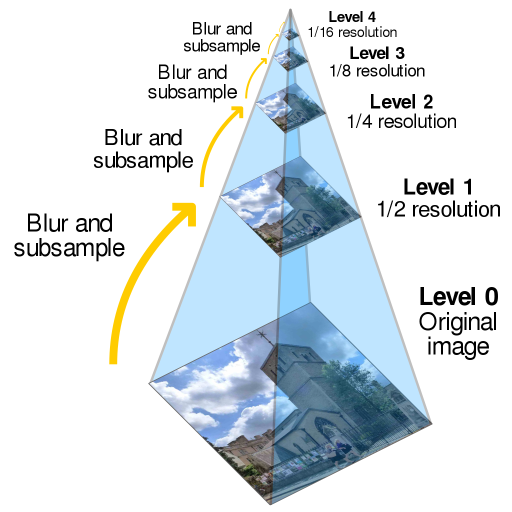

In [ ]:
# === Parameters ===
INDICES = [0, 1, 3]          # which file indices to merge (e.g., [0,2,3] or list(range(0,4)))
LEVEL = 4                       # pyramid level to read from each OME-TIFF
PREFIX = "morphology_focus"     # filename prefix before index: {PREFIX}_{index:04d}.ome.tif
IN_DIR = "."                    # input directory
OUT_DIR = "."                   # output directory
OUTTAG = None                   # optional tag for merged name (e.g., "DAPI_MEMB"); None -> auto

# Global defaults (used when a channel isn't listed below)
LOW_PCT_DEFAULT  = 1.0     # baseline subtract (0–5 typical)
HIGH_PCT_DEFAULT = 99.8    # clip bright outliers (99–99.9 typical)

# Per-channel overrides: {index: (low_pct, high_pct)}
PER_CHANNEL_CUTOFFS = {
    0: (5, 99.9),
    1: (5, 99.6),
    3: (5, 99.7),
    # 3 not listed -> uses defaults
}

# Colors for the tinted previews/merge (wraps if more channels than colors)
DEFAULT_COLORS = [
   (  0,   0, 255),  # blue
    (255,   0,   0),  # red
    (255, 255,   0),  # yellow
    (  0, 255,   0),  # green
    (255,   0, 255),  # magenta
    (  0, 255, 255),  # cyan
    (255, 128,   0),  # orange
    (128,   0, 255),  # violet
]

In [64]:
from pathlib import Path
import numpy as np
import tifffile as tf
from PIL import Image

def to_uint8(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32, copy=False)
    lo, hi = np.percentile(x, (1.0, 99.9))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = x.min(), x.max()
    if hi <= lo:
        return np.zeros_like(x, dtype=np.uint8)
    x = (np.clip(x, lo, hi) - lo) / (hi - lo)
    return (x * 255).astype(np.uint8)

from pathlib import Path
import numpy as np
import tifffile as tf
from PIL import Image

def read_level_grayscale(fp: Path, level: int) -> np.ndarray:
    arr = tf.imread(str(fp), is_ome=False, level=level)
    if arr.ndim == 2:
        return arr
    if arr.ndim == 3:
        if arr.shape[-1] == 1:
            return arr[..., 0]
        if arr.shape[0] == 1:
            return arr[0]
        return arr[0] if arr.shape[0] < arr.shape[-1] else arr[..., 0]
    raise ValueError(f"Unexpected array shape {arr.shape} in {fp}")

def bg_correct(img: np.ndarray, low_pct: float, high_pct: float) -> np.ndarray:
    """
    Minimal background/outlier handling per channel:
      - subtract low_pct percentile (baseline)
      - clip to high_pct percentile (remove hot outliers)
    Returns float32 >= 0 in the range [0, hi-lo].
    """
    x = img.astype(np.float32, copy=False)
    lo = np.percentile(x, low_pct)
    hi = np.percentile(x, high_pct)
    if not np.isfinite(lo): lo = x.min()
    if not np.isfinite(hi): hi = x.max()
    if hi <= lo:
        return np.zeros_like(x, dtype=np.float32)
    x = x - lo
    x[x < 0] = 0.0
    cap = hi - lo
    x[x > cap] = cap
    return x

def to_uint8_linear(x: np.ndarray) -> np.ndarray:
    """
    Linearly scale 0..max(x) -> 0..255 to preserve the bg_correct window.
    """
    x = x.astype(np.float32, copy=False)
    m = x.max()
    if not np.isfinite(m) or m <= 0:
        return np.zeros_like(x, dtype=np.uint8)
    return np.clip((x / m) * 255.0, 0, 255).astype(np.uint8)

def get_cutoffs_for_index(i: int) -> tuple[float, float]:
    low, high = PER_CHANNEL_CUTOFFS.get(i, (LOW_PCT_DEFAULT, HIGH_PCT_DEFAULT))
    # sanity guard
    low = float(low); high = float(high)
    if not (0.0 <= low < high <= 100.0):
        raise ValueError(f"Invalid cutoffs for index {i}: {(low, high)}")
    return low, high

In [87]:
in_dir = Path(IN_DIR)
out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)

chans = []
shapes = []
for i in INDICES:
    fp = in_dir / f"{PREFIX}_{i:04d}.ome.tif"
    if not fp.exists():
        print(f"WARNING: missing {fp}, skipping.")
        continue

    raw = read_level_grayscale(fp, level=LEVEL)
    shapes.append(raw.shape)

    low_pct, high_pct = get_cutoffs_for_index(i)
    corr = bg_correct(raw, low_pct=low_pct, high_pct=high_pct)
    corr_u8 = to_uint8_linear(corr)  # preserves your per-channel window

    # Save corrected grayscale
    out_gray = out_dir / f"{PREFIX}_{i:04d}_L{LEVEL}_GRAY_CORR_lp{low_pct}_hp{high_pct}.png"
    Image.fromarray(corr_u8, mode="L").save(out_gray)
    print(f"Saved {out_gray}")

    chans.append((i, corr_u8))

if not chans:
    raise SystemExit("No valid inputs found after reading indices.")

H, W = chans[0][1].shape
if any(ch[1].shape != (H, W) for ch in chans):
    raise ValueError(f"All inputs must match shape at level {LEVEL}. Got: {set(shapes)}")

# Colorize & merge
merged = np.zeros((H, W, 3), dtype=np.uint16)
for c, (i, img8) in enumerate(chans):
    color = DEFAULT_COLORS[c % len(DEFAULT_COLORS)]
    rgb = np.zeros((H, W, 3), dtype=np.uint16)
    for k in range(3):
        rgb[..., k] = (img8.astype(np.uint16) * color[k]) // 255

    out_c = out_dir / f"{PREFIX}_{i:04d}_L{LEVEL}_COLOR.png"
    Image.fromarray(np.clip(rgb, 0, 255).astype(np.uint8), mode="RGB").save(out_c)
    print(f"Saved {out_c}")

    merged += rgb

merged = np.clip(merged, 0, 255).astype(np.uint8)
if OUTTAG:
    merged_name = f"{PREFIX}_L{LEVEL}_MERGE_{OUTTAG}.png"
else:
    merged_name = f"{PREFIX}_L{LEVEL}_MERGE_from_{INDICES[0]:04d}-to-{INDICES[-1]:04d}.png"
out_merged = out_dir / merged_name
Image.fromarray(merged, mode="RGB").save(out_merged)
print(f"Saved merged composite {out_merged}")

Saved morphology_focus_0000_L2_GRAY_CORR_lp5.0_hp99.9.png
Saved morphology_focus_0001_L2_GRAY_CORR_lp5.0_hp99.6.png
Saved morphology_focus_0003_L2_GRAY_CORR_lp5.0_hp99.7.png
Saved morphology_focus_0000_L2_COLOR.png
Saved morphology_focus_0001_L2_COLOR.png
Saved morphology_focus_0003_L2_COLOR.png
Saved merged composite morphology_focus_L2_MERGE_from_0000-to-0003.png
